In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

### loading data from obj

In [2]:
import pickle
from MD import MD_sys
with open('sys.obj', 'rb') as f:
    sys = pickle.load(f) 

### saving data to XYZ file

In [3]:
def save_data(sys, fname):
    from tools import to_xyz, logging_dict
    logging_dict(sys.short_info())
    print(f'saving data to {fname}')
    with open(fname, 'wb') as f:
        for i,r in enumerate(sys.r_li[::20]):
            to_xyz(f, f'frame {i}', r, name='C')  
            
# save_data(sys, 'frames.xyz')

### MPL settings

In [4]:
settings = {
    'font.size': 18,
    'figure.figsize': (15, 7)
}
plt.rcParams.update(settings)

### Energy profile

Calculating potential...


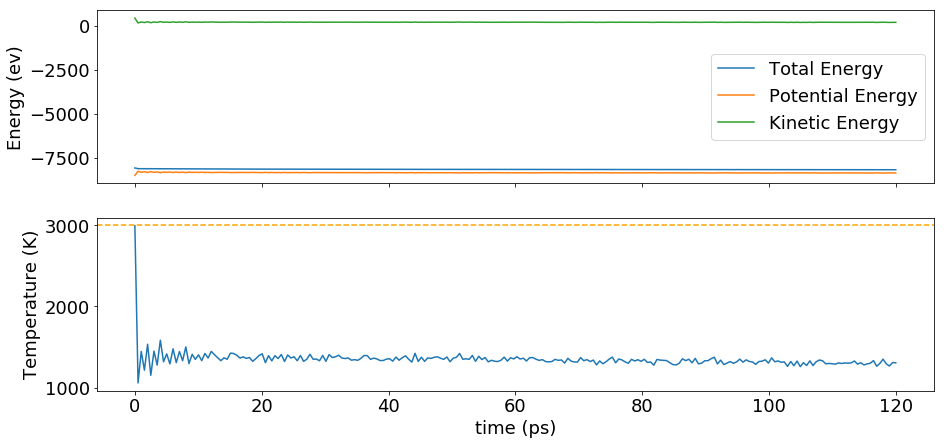

In [24]:
def energy_profile(sys, jump=50):
    from tersoff import tersoff_V
    from analysis import temperature
    K = np.array(sys.K[::jump])
    print('Calculating potential...')
    V = np.fromiter((tersoff_V(r) for r in sys.r_li[::jump]), dtype=float)
    E = K + V
    T = temperature(K, sys.N, sys.k)
    t = np.linspace(0, sys.t_total, V.size)
    
    fig, axes = plt.subplots(2, figsize=(15,7), sharex=True)
    axes[0].plot(t, E, label='Total Energy')
    axes[0].plot(t, V, label='Potential Energy')
    axes[0].plot(t, K, label='Kinetic Energy')
    axes[0].legend()
    axes[0].set(ylabel='Energy (ev)')
    
    axes[1].plot(t, T)
    axes[1].set(xlabel='time (ps)', ylabel='Temperature (K)')
    axes[1].axhline(sys.T, ls='--', color='orange', label='Temperature Set')
    plt.show()
    fig.savefig('statistics/energy.pdf')
    
energy_profile(sys)

### Autocorrelation

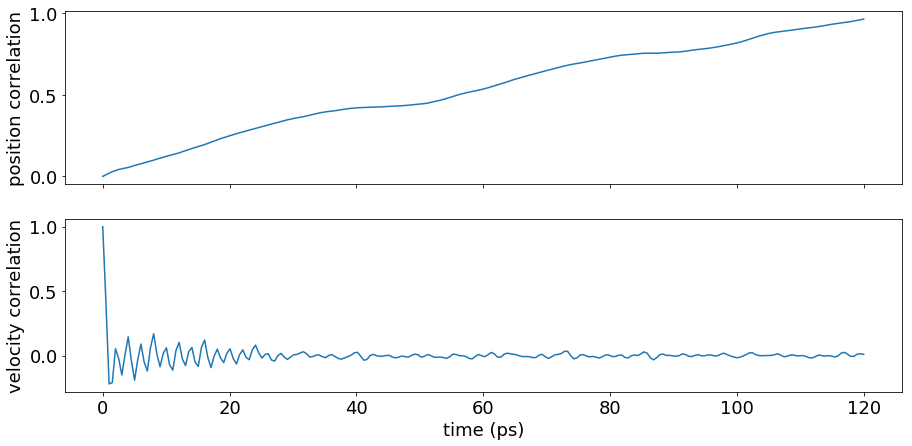

In [25]:
def auto_corr_profile(sys, jump=50):
    from analysis import Correlation
    R_corr, V_corr = Correlation(sys.r_li[::jump], sys.v_li[::jump])
    t = np.linspace(0, sys.t_total, R_corr.size)
    
    fig, axes = plt.subplots(2, sharex=True)
    axes[0].plot(t, R_corr)
    axes[0].set(ylabel='position correlation')
    axes[1].plot(t, V_corr)
    axes[1].set(xlabel='time (ps)', ylabel='velocity correlation')
    plt.show(fig)
    fig.savefig('statistics/autocorrelation.pdf')
    
auto_corr_profile(sys)

### Radial Distribution Function(RDF) & Angular Distribution Function(ADF)

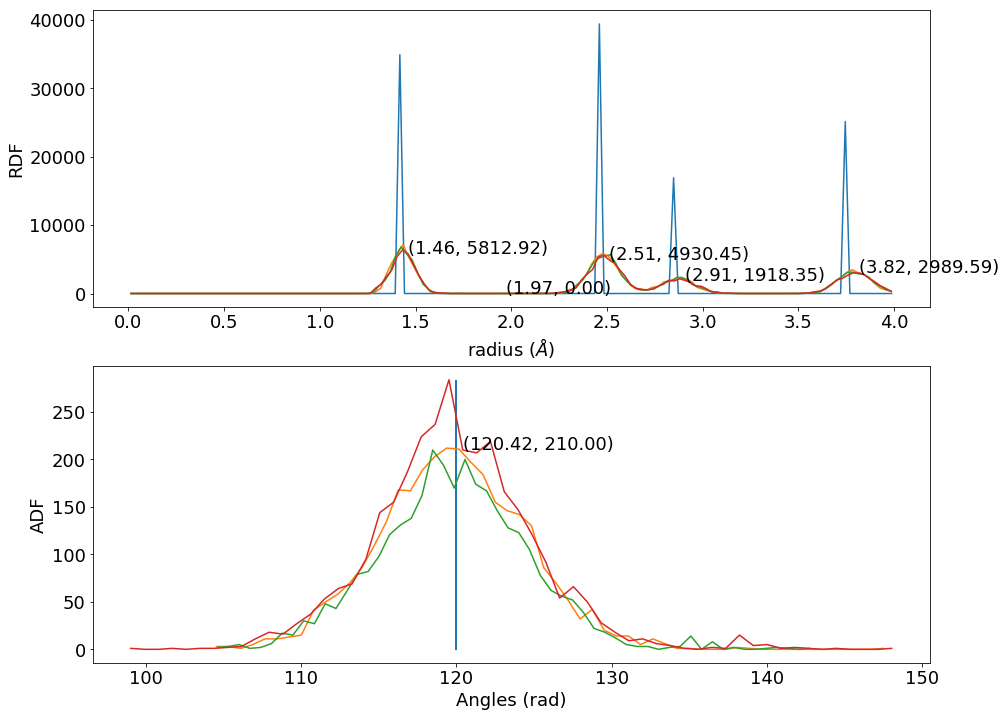

In [26]:
def DF_profile(sys):
    from analysis import percent_ind, plot_peaks, hist, RDF, ADF
    percents = [0, 0.2, 0.5, 1]
    
    fig, axes = plt.subplots(2, figsize=(15,12))
    for i,pos in enumerate(percent_ind(sys.r_li, percents)):
        rs, gs = RDF(pos)
        axes[0].plot(rs, gs, label=f'time:{round(sys.t_total * percents[i],2)}')
        axes[0].set(xlabel='radius ($\AA$)', ylabel='RDF')
    plot_peaks(rs, gs, axes[0])
    for i,r in enumerate(percent_ind(sys.r_li, percents)):
        thetas = ADF(r)
        xs, ys = hist(thetas)
        axes[1].plot(xs, ys,label=f'time:{round(sys.t_total * percents[i],2)}')
        axes[1].set(xlabel='Angles (rad)', ylabel='ADF')
    plot_peaks(xs, ys, axes[1])
    plt.show(fig)
    fig.savefig('statistics/DF.pdf')
    
DF_profile(sys)

### Neighboring particles

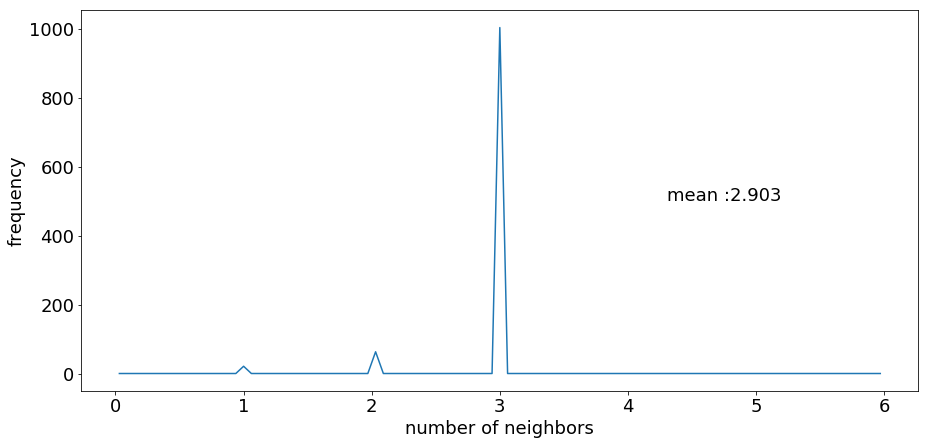

In [27]:
def Neighbor_profile(r):
    from analysis import hist, Neighbors
    neighbors = Neighbors(r)
    xs, ys = hist(neighbors, boundary=(0,6))
    mean_neighbors = round(neighbors.mean(),3)
    
    fig, ax = plt.subplots()
    ax.plot(xs, ys)
    ax.annotate(f'mean :{mean_neighbors}', xy=(0.7,0.5), xycoords='axes fraction')
    ax.set(xlabel='number of neighbors', ylabel='frequency')
    
    plt.show(fig)
    fig.savefig('statistics/neighbors.pdf')
    
Neighbor_profile(sys.r)

### Virial Stress

In [17]:
def virial_profile(sys):
    from analysis import Virial_Stress
    Virial = Virial_Stress(sys.r, sys.v, sys.m, sys.L)
    return Virial

virial_profile(sys)

array([[ 0.00142596, -0.001362  , -0.00013247],
       [-0.001362  ,  0.00505637,  0.00045082],
       [-0.00013247,  0.00045082, -0.00677063]])

### Tracking the z direction of a few particles

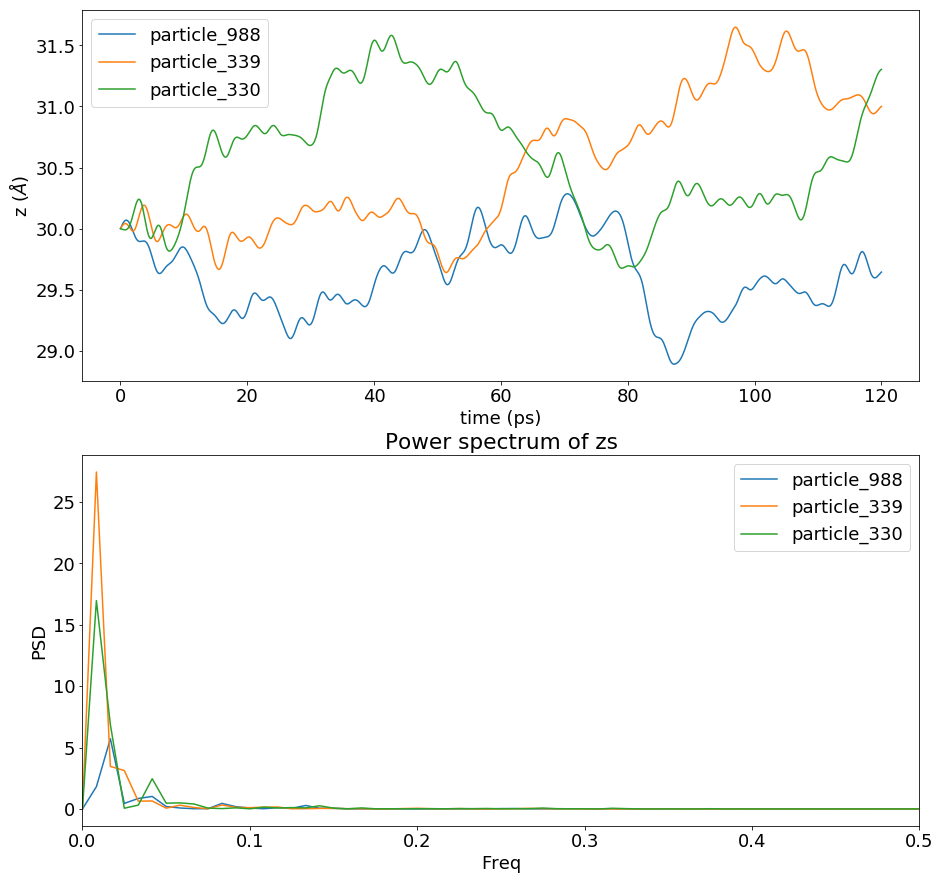

In [29]:
def track_z(sys):
    from analysis import particle_track
    probes, probe_inds = particle_track(3, sys.r_li, sys.outer_ind)
    t = np.linspace(0, sys.t_total, probes.shape[1])
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    for probe, ind in zip(probes, probe_inds):
        axes[0].plot(t, probe, label=f'particle_{ind}')
        axes[1].plot(*signal.periodogram(probe, 1/sys.dt), label=f'particle_{ind}')
    axes[0].set(xlabel='time (ps)', ylabel='z ($\AA$)')
    axes[1].set(title='Power spectrum of zs', xlabel='Freq', ylabel='PSD', 
                yscale='linear', xscale='linear' ,xlim=(0, .5))
    axes[0].legend()
    axes[1].legend()
    plt.show(fig)
#     fig.savefig('statistics/z_track.pdf')
    
track_z(sys)

In [ ]:
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

r = sys.r_li[100]
xs, ys, zs = r[:, 0], r[:, 1], r[:, 2]
# xs = np.linspace(r[:,0].min(), r[:,0].max(), 100)
# ys = np.linspace(r[:,1].min(), r[:,1].max(), 100)
# xx, yy = np.meshgrid(xs, ys)
# zz = r[:, 2].reshape(r[:,0].shape[0], r[:,1].shape[0])
# grid = griddata(r[:, :2], r[:, 2], (xx, yy))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys ,zs, )
ax.set(zlim=(27,37))
plt.show(fig)